# **DC-GAN** (**D**eep **C**onvolutional **G**enerative **A**dversarial **N**etwork)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob
from PIL import Image
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import Reshape, Conv2DTranspose, ReLU, LeakyReLU, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.models import Sequential

print("TF version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TF version: 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **1. Load and prepare the dataset**

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [2]:
(train_images, train_labels), (_, _) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images) / 255  # Normalize the images to [0, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **2. Create the models**

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [3]:
noise_dim = 100 #100

### The Generator


In [4]:
def make_generator_model(noise_dim: int) -> Sequential:
    model = Sequential(name="DCGAN_Generator_Model")
    
    # Reshape the input noise vector into a 4D tensor
    # model.add(Reshape((1, 1, 64), input_shape=(noise_dim,)))
    model.add(Reshape((1, 1, noise_dim), input_shape=(noise_dim,)))
    
    # First Conv2DTranspose layer
    model.add(Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='valid'))
    # model.add(Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Second Conv2DTranspose layer
    model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='valid'))
    # model.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Third Conv2DTranspose layer
    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Final Conv2DTranspose layer to produce the output image
    model.add(Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='tanh'))
    
    return model

generator = make_generator_model(noise_dim)
generator.summary()

Model: "DCGAN_Generator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 3, 3, 256)        230656    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 7, 7, 128)        295040    
 ranspose)                                                       
                                             

Use the (as yet untrained) generator to create an image.

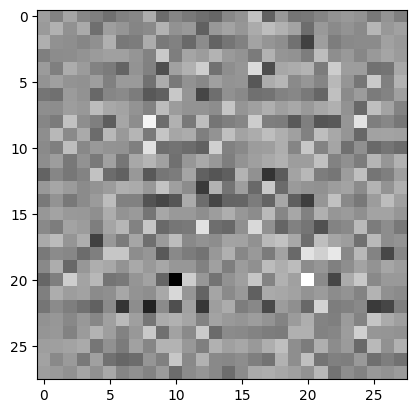

In [5]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# normaliza los valores de la imagen antes de mostrarla
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

In [6]:
def make_discriminator_model() -> Sequential:
    model = Sequential(name="DCGAN_Discriminator_Model")
    
    # First Conv2D layer
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    
    # Second Conv2D layer
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    
    # Third Conv2D layer
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "DCGAN_Discriminator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 16)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                         

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [7]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49967298]], shape=(1, 1), dtype=float32)


## **3. Define the loss and optimizers**

Define loss functions and optimizers for both models.


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy()

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [9]:
def discriminator_loss(disc_real_output: tf.Tensor, disc_fake_output: tf.Tensor) -> tf.Tensor:
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = cross_entropy(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [10]:
def generator_loss(disc_fake_output: tf.Tensor) -> tf.Tensor:
    return cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [11]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [12]:
checkpoint_dir = 'results_p2/DC_GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## **4. Define the training loop**


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [13]:
num_examples_to_generate = 16

# You will reuse this seed overtime 
# (so it's easier to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images: tf.Tensor) -> None:
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:     
        generated_images = generator(noise, training=True)
        
        disc_real_output = discriminator(images, training=True)
        disc_fake_outputs = discriminator(generated_images, training=True)

        gen_loss = generator_loss(disc_fake_outputs)
        disc_loss = discriminator_loss(disc_real_output, disc_fake_outputs)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

**Generate and save images**

In [14]:
def generate_and_save_images(model: Sequential, epoch: int, test_input: np.ndarray, show_figure: bool) -> None:
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions: np.ndarray = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap="gray")
        plt.axis("off")

    plt.savefig(f"results_p2/DC_GAN/epochs/DCGAN_epoch_{epoch:03d}.png")
    if show_figure:
        plt.show()
    plt.close()

In [15]:
def train(dataset: tf.data.Dataset, epochs: int, trace: int) -> None:
    gen_loss_history = []
    disc_loss_history = []
    total_start = time.time()
    for epoch in range(epochs):
        start = time.time()

        gen_episode_loss = 0
        disc_episode_loss = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_episode_loss += gen_loss
            disc_episode_loss += disc_loss

        generate_and_save_images(model=generator, epoch=epoch, test_input=seed, show_figure=False)

        if epoch % trace == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f'Epoch {epoch}: {time.time()-start:.2f} secs, gen loss: {gen_episode_loss / BATCH_SIZE}, disc loss: {disc_episode_loss / BATCH_SIZE}')

        gen_loss_history.append(gen_episode_loss / BATCH_SIZE)
        disc_loss_history.append(disc_episode_loss / BATCH_SIZE)

    generate_and_save_images(model=generator, epoch=epochs, test_input=seed, show_figure=True)
    minutos, segundos = divmod(time.time()-total_start, 60)
    print(f"*******Total training time: {int(minutos)} mins y {segundos:.2f} secs*******")

    return gen_loss_history, disc_loss_history

## **5. Train the model**
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Epoch 0: 3.83 secs, gen loss: 0.22601452469825745, disc loss: 2.307095766067505
Epoch 50: 1.97 secs, gen loss: 2.256507158279419, disc loss: 0.4792047142982483
Epoch 100: 1.80 secs, gen loss: 1.187548279762268, disc loss: 0.9603380560874939
Epoch 150: 1.84 secs, gen loss: 0.878816545009613, disc loss: 1.1177279949188232
Epoch 200: 1.81 secs, gen loss: 0.7879250049591064, disc loss: 1.1709082126617432
Epoch 250: 1.81 secs, gen loss: 0.732822835445404, disc loss: 1.2180668115615845
Epoch 300: 1.82 secs, gen loss: 0.7063713073730469, disc loss: 1.2313268184661865
Epoch 350: 1.83 secs, gen loss: 0.6959706544876099, disc loss: 1.2340319156646729
Epoch 400: 1.82 secs, gen loss: 0.6782490015029907, disc loss: 1.2502690553665161
Epoch 450: 2.32 secs, gen loss: 0.6637135148048401, disc loss: 1.2579323053359985


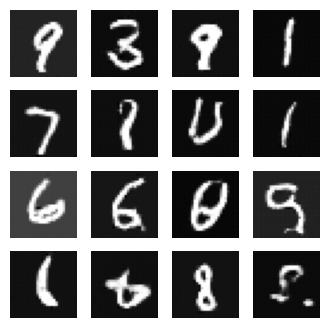

*******Total training time: 14 mins y 52.14 secs*******


In [16]:
EPOCHS = 500
trace = 50
gen_loss_history, disc_loss_history = train(train_dataset, EPOCHS, trace)

## **GAN losses history**

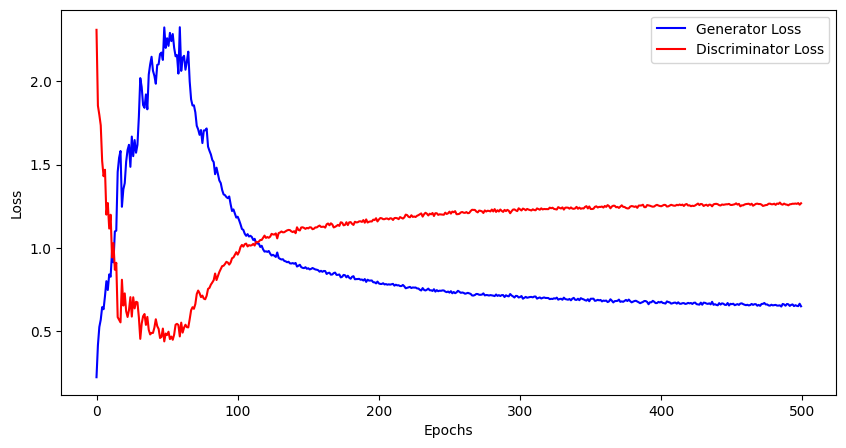

In [17]:
def plot_loss(gen_loss: list, disc_loss: list) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss, label="Generator Loss", color="blue")
    plt.plot(disc_loss, label="Discriminator Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"results_p2/DCGAN_{EPOCHS}_loss_history.png")
    plt.show()

plot_loss(gen_loss_history, disc_loss_history)

**Restore the latest checkpoint.**

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **6. Create a GIF**

In [ ]:
def create_gif_from_folder(folder_path: str, output_filename: str, duration: int) -> None:
    image_files = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    frames = [Image.open(file) for file in image_files]
    frames[0].save(
        output_filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=1
    )

create_gif_from_folder(folder_path="results_p2/DC_GAN/epochs", output_filename=f"results_p2/DCGAN_{EPOCHS}_results.gif", duration=30)

**Remove all folder images**

In [27]:
def remove_all_images(folder: str, extension: str = 'jpeg') -> None:
    image_files = glob.glob(os.path.join(folder, f'*.{extension}'))
    for image_file in image_files:
        os.remove(image_file)
    print(f"Removed {len(image_files)} {extension} images from {folder}")

remove_all_images('results_p2/DC_GAN/epochs')

Removed 0 jpeg images from results_p2/DC_GAN/epochs
